<a href="https://colab.research.google.com/github/agpascoe/NN_experiments/blob/main/Pytorch/EMINST47_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm import tqdm
from timeit import default_timer as timer

This is a notebook for solving the EMINST recognition problem using pytorch


In [ ]:
# importing libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
#downloading the data
#check the api specification at https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html

rawData = torchvision.datasets.EMNIST(root='emnist',split='balanced',download=True)


  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [ ]:
# lets inspect what we download
print(rawData)

Dataset EMNIST
    Number of datapoints: 112800
    Root location: emnist
    Split: Train


In [ ]:
print(np.array(rawData.classes).shape, rawData.classes) #this shows the different classes of the elements ('A'..'Z' + '0' .. '9' + others, sum 47 characteres)

(47,) ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [ ]:
print(rawData.targets.shape) #this shows tha targets shape


torch.Size([112800])


In [ ]:

print(rawData.data.shape) #this shows the shape of data, 124800 images of 28x82 pixels 

torch.Size([112800, 28, 28])


Text(0.5, 1.0, 'h')

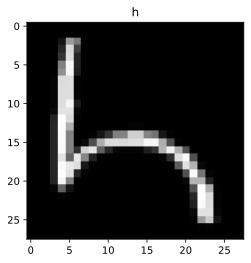

In [ ]:
#lets see a random choice image.. check that we need to traspose the image to see it as we used to
choice = np.random.randint(rawData.data.shape[0])
plt.imshow(rawData.data[choice,:,:].T,cmap='gray')
plt.title(rawData.classes[rawData.targets[choice]])

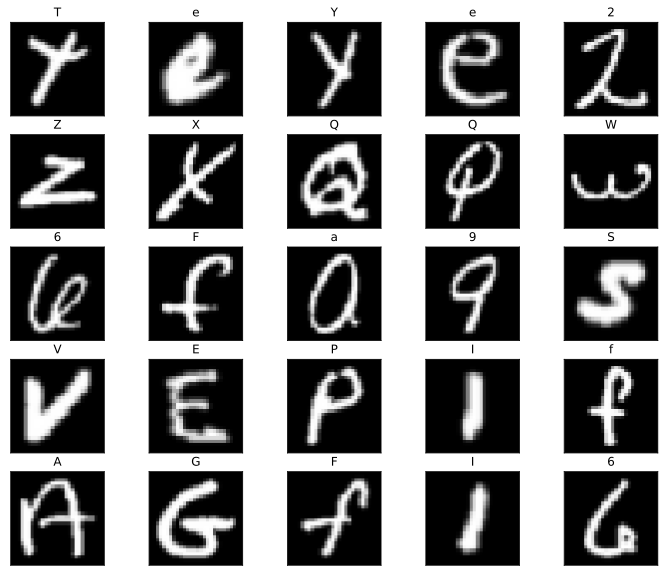

In [ ]:
#lets print not one but 25 images in 5 x 5 rows.
fig,axs = plt.subplots(5,5,figsize=(12,10))

for i,ax in enumerate(axs.flatten()):

  choice = np.random.randint(rawData.data.shape[0])

  ax.imshow(rawData.data[choice,:,:].T,cmap='gray')
  ax.set_title(rawData.classes[rawData.targets[choice]])
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [ ]:
#let's see how balanced are the data.
type_char = np.zeros(np.array(rawData.classes).shape)
print(type_char.shape)
for i in range(rawData.data.shape[0]):
    type_char[rawData.targets[i]]+=1


print(type_char)

(47,)
[2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400.
 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400.
 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400.
 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400. 2400.]


(array([2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400.,
        2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400.,
        2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400.,
        2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400.,
        2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400., 2400.,
        2400., 2400.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 47 Patch objects>)

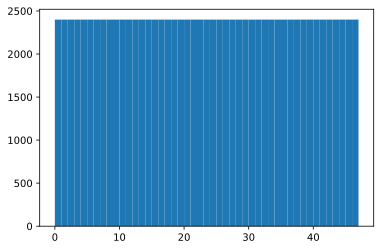

In [ ]:
plt.hist(rawData.targets,range(0,48)) #ok.. data is balanced

In [ ]:
data = (rawData.data)/255. #estandarizing data
data = data.view(rawData.data.shape[0], 1, rawData.data.shape[1], rawData.data.shape[1] )

In [ ]:
labels = rawData.targets #separating labels
classes = rawData.classes #and classes



In [ ]:
data.shape, labels.shape

(torch.Size([112800, 1, 28, 28]), torch.Size([112800]))

In [ ]:
#lets separate data in datasets.
# first to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1) #leave 10% for testing

# Converting into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Translating into dataloader objects with batches of 32 samples
batchsize    = 32
trainLoader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
testLoader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [ ]:
( trainLoader.dataset.tensors[0].shape,  trainLoader.dataset.tensors[1].shape )

(torch.Size([101520, 1, 28, 28]), torch.Size([101520]))

In [ ]:
( testLoader.dataset.tensors[0].shape,  testLoader.dataset.tensors[1].shape )

(torch.Size([11280, 1, 28, 28]), torch.Size([11280]))

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.pooling import MaxPool2d
#lets create the model class

class eminstNet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # print toggle

      self.layers= nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.MaxPool2d(2,2),
          nn.BatchNorm2d(6),
          nn.LeakyReLU(2,2),
          # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)
          
          # second convolution layer
          nn.Conv2d(6,6,3,padding=1),
          nn.MaxPool2d(2,2),
          nn.BatchNorm2d(6),
          nn.LeakyReLU(),
          # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)
      
          nn.Flatten(),
          nn.Linear(7*7*6,200),
          nn.LeakyReLU(),
          nn.Linear(200,100),
          nn.LeakyReLU(),
          nn.Linear(100,47),
      )


    def forward(self,x):
      x = self.layers(x)
      
      return x



In [ ]:
#instantiating a dummy model just for seeing everythings look well!
net2 = eminstNet()
X,y = iter(trainLoader).next()
print(X.shape, y.shape)
y_Hat = net2(X)
print (y_Hat.shape)


torch.Size([32, 1, 28, 28]) torch.Size([32])
torch.Size([32, 47])


In [ ]:
#make a trainning function

def fit(net, trainLoader, testLoader, numEpochs=10):
  
  startTime = timer()
  results={
      'trainLoss' : [],
      'testLoss'  : [],
      'trainAcc'  : [],
      'testAcc'   : []
  }

  net.to(device)
  lossFunction = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=0.001)


  # loop over epochs
  for epochi in range(numEpochs): #to show a bar for advancing
  
    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    
    print(f"\n Epoch: {epochi+1} of {numEpochs} with {len(trainLoader)} batches of {batchsize} Samples ")
    for X,y in tqdm(trainLoader):

      # push data to GPU
           
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossFunction(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    results['trainLoss'].append(np.mean(batchLoss))
    results['trainAcc'].append(100*np.mean(batchAcc))

    ### test performance
    net.eval()
    X,y = next(iter(testLoader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossFunction(yHat,y)
      
    # get loss and error rate from the test batch
    results['testLoss'].append(loss.item())
    results['testAcc'].append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())

    print(f"\nTrainning lost: {results['trainLoss'][-1]:.2f} .. trainning Accuracy: {results['trainAcc'][-1]:.2f}% | Test loss: {results['testLoss'][-1]:.2f}  ..,test Accuracy: {results['testAcc'][-1]:.2f}%")
  # end epochs
  
  endTime = timer()
  print(f"Total trainning time for {numEpochs} epochs in {endTime-startTime:.2f} seconds")  
  # function output
  
  return results, yHat

##Let's run our first model


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



net_cero=eminstNet()
# summary info
from torchsummary import summary
summary(net_cero.to(device),(1,28,28))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
         MaxPool2d-2            [-1, 6, 14, 14]               0
       BatchNorm2d-3            [-1, 6, 14, 14]              12
         LeakyReLU-4            [-1, 6, 14, 14]               0
            Conv2d-5            [-1, 6, 14, 14]             330
         MaxPool2d-6              [-1, 6, 7, 7]               0
       BatchNorm2d-7              [-1, 6, 7, 7]              12
         LeakyReLU-8              [-1, 6, 7, 7]               0
           Flatten-9                  [-1, 294]               0
           Linear-10                  [-1, 200]          59,000
        LeakyReLU-11                  [-1, 200]               0
           Linear-12                  [-1, 100]          20,100
        LeakyReLU-13                  [-1, 100]               0
           Linear-14                   

In [ ]:
results_cero, yHat = fit(net_cero, trainLoader, testLoader, 6)


 Epoch: 1 of 6 with 3172 batches of 32 Samples 


100%|██████████| 3172/3172 [00:12<00:00, 251.69it/s]



Trainning lost: 0.72 .. trainning Accuracy: 77.05% | Test loss: 0.47  ..,test Accuracy: 84.06%

 Epoch: 2 of 6 with 3172 batches of 32 Samples 


100%|██████████| 3172/3172 [00:12<00:00, 262.88it/s]



Trainning lost: 0.43 .. trainning Accuracy: 84.68% | Test loss: 0.42  ..,test Accuracy: 85.47%

 Epoch: 3 of 6 with 3172 batches of 32 Samples 


100%|██████████| 3172/3172 [00:11<00:00, 266.07it/s]



Trainning lost: 0.38 .. trainning Accuracy: 86.38% | Test loss: 0.40  ..,test Accuracy: 85.43%

 Epoch: 4 of 6 with 3172 batches of 32 Samples 


100%|██████████| 3172/3172 [00:12<00:00, 252.03it/s]



Trainning lost: 0.35 .. trainning Accuracy: 87.30% | Test loss: 0.39  ..,test Accuracy: 86.05%

 Epoch: 5 of 6 with 3172 batches of 32 Samples 


100%|██████████| 3172/3172 [00:13<00:00, 229.80it/s]



Trainning lost: 0.32 .. trainning Accuracy: 88.08% | Test loss: 0.39  ..,test Accuracy: 86.57%

 Epoch: 6 of 6 with 3172 batches of 32 Samples 


100%|██████████| 3172/3172 [00:13<00:00, 239.78it/s]



Trainning lost: 0.30 .. trainning Accuracy: 88.51% | Test loss: 0.40  ..,test Accuracy: 86.09%
Total trainning time for 6 epochs in 77.17 seconds


In [ ]:
#let's make a function for plotting net results

def plot_Net(results):
  fig,ax = plt.subplots(1,2,figsize=(16,5))

  ax[0].plot(results['trainLoss'],'s-',label='Train')
  ax[0].plot(results['testLoss'],'o-',label='Test')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss (MSE)')  
  ax[0].set_title('Model loss')

  ax[1].plot(results['trainAcc'],'s-',label='Train')
  ax[1].plot(results['testAcc'],'o-',label='Test')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Error rates (%)')
  ax[1].set_title(f"Final model test Accuracy: {results['testAcc'][-1]:.2f}%")
  ax[1].legend()

  plt.show()

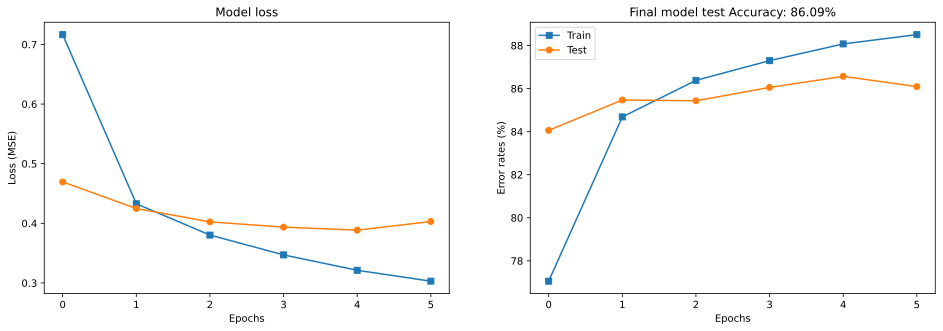

In [ ]:
plot_Net(results_cero)

In [ ]:
#Use the code at beginning of notebook to show some ranndom images
def plot_random_results(testLoader, yHat):
  
  fig,axs = plt.subplots(10,5,figsize=(12,20))

  for i,ax in enumerate(axs.flatten()):

    choice = np.random.randint(yHat.shape[0])
    color = 'gray' if (torch.argmax(yHat[choice]) == testLoader.dataset.tensors[1][choice]) else 'hot'
    ax.imshow(testLoader.dataset.tensors[0][choice].squeeze().T,cmap=color)
    ax.set_title(f"pred:{classes[torch.argmax(yHat[choice])]} vs {classes[testLoader.dataset.tensors[1][choice]]}" )
    ax.set_xticks([])
    ax.set_yticks([])

  plt.show()

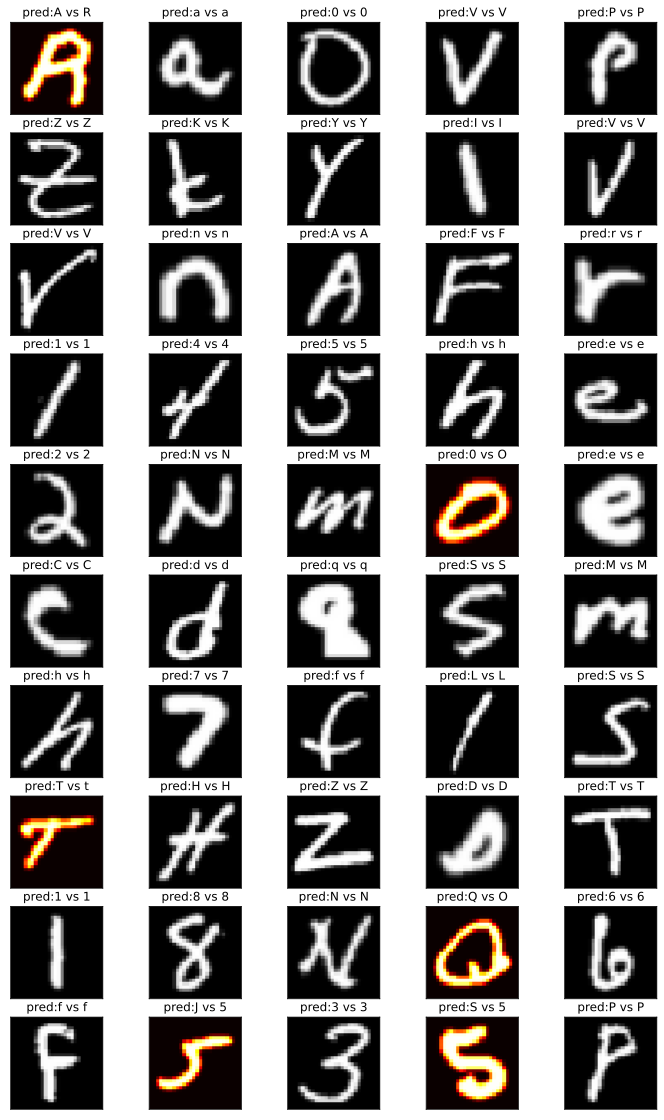

In [ ]:
plot_random_results(testLoader, yHat)